In [2]:
import zipfile
import os

zip_file_path = '/content/GTSRB (2).zip'
extract_to_path = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f'Successfully extracted {zip_file_path} to {extract_to_path}')

# Rename the extracted folder from 'GTSRB' to 'GTSRB_dataset'
# This is necessary because the original script looks for 'GTSRB' as the parent directory.
# Based on the problem description, it seems the original script assumes 'train_modified' and 'test_modified'
# are directly under 'GTSRB'. Let's ensure the folder structure is correct.

# Check if a folder named 'GTSRB' exists after extraction
if os.path.exists(os.path.join(extract_to_path, 'GTSRB')):
    # List contents of GTSRB to see if it contains train_modified and test_modified
    gtsrb_contents = os.listdir(os.path.join(extract_to_path, 'GTSRB'))
    if 'train_modified' in gtsrb_contents and 'test_modified' in gtsrb_contents:
        # The path expected by the original script is '/content/GTSRB/train_modified'
        # and '/content/GTSRB/test_modified'.
        # The zip file extracts a folder named 'GTSRB'.
        # So the original paths are correct IF the GTSRB folder is extracted directly under /content.
        # If the zip file contains a folder named 'GTSRB' and then inside 'train_modified', etc.
        # Let's verify the actual structure after extraction.
        print("The 'GTSRB' folder exists in the extracted path.")
        print("Contents of /content/GTSRB:", os.listdir(os.path.join(extract_to_path, 'GTSRB')))

    elif 'GTSRB' in gtsrb_contents: # This means it extracted /content/GTSRB/GTSRB/train_modified
        # If the zip contains GTSRB/GTSRB/... then we need to move the inner GTSRB out
        print("Detected nested 'GTSRB' folder structure. Correcting...")
        nested_gtsrb_path = os.path.join(extract_to_path, 'GTSRB', 'GTSRB')
        final_gtsrb_path = os.path.join(extract_to_path, 'GTSRB_corrected') # Use a temporary name

        if os.path.exists(nested_gtsrb_path):
            os.rename(nested_gtsrb_path, final_gtsrb_path)
            os.rmdir(os.path.join(extract_to_path, 'GTSRB')) # Remove the empty outer GTSRB
            os.rename(final_gtsrb_path, os.path.join(extract_to_path, 'GTSRB')) # Rename back to GTSRB
            print("Corrected folder structure: '/content/GTSRB' now points to the correct data.")
else:
    print("No 'GTSRB' folder found directly after extraction. Checking contents of /content...")
    if 'GTSRB' in os.listdir(extract_to_path):
        print("A 'GTSRB' folder already exists at the root of the extraction path.")
    else:
        print("It seems the zip file extracted contents directly into /content, or to a different named folder.")
        print("Please verify the contents of the zip file or the expected directory structure.")

# Ensure the TRAIN_PATH and TEST_PATH variables are correctly pointing to the new location.
# Assuming the zip extracts to /content/GTSRB/train_modified and /content/GTSRB/test_modified
# which matches the original TRAIN_PATH and TEST_PATH variables.


Successfully extracted /content/GTSRB (2).zip to /content
The 'GTSRB' folder exists in the extracted path.
Contents of /content/GTSRB: ['train_modified', 'test_modified']


TRAIN_PATH: /content/GTSRB/train_modified
TEST_PATH: /content/GTSRB/test_modified
Train images: 3977, Test images: 1983
Number of classes: 43
Images with SIFT descriptors (train): 3622
All descriptors shape: (73722, 128)
X_train_bovw shape: (3977, 400)
X_test_bovw shape: (1983, 400)
Ξεκινάει το grid search στο C...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 1}
Best CV score: 0.6069897644592429

✅ Τελικό SVM+BOVW στο GTSRB (K=400, best C=1) – Test Accuracy: 0.5598

📊 Classification report (SVM + BoVW, Hellinger, balanced SVM):
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.86      0.83      0.84       114
          10       0.69      0.57      0.62       104
          11       0.86      0.82      0.84        66
          12       0.44      0.63      0.52       109
          13       0.66      0.75      0.70       114
          14       1.00      0.74      0.85        42

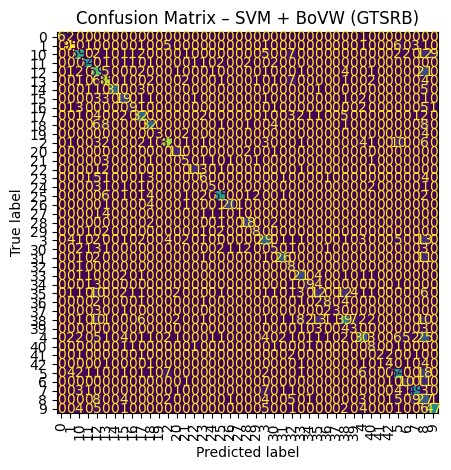

In [7]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# --------------------------------------------------
# 0. Paths (Corrected based on previous extraction)
# --------------------------------------------------
# The zip file was extracted by the previous cell into /content/GTSRB/train_modified and /content/GTSRB/test_modified
TRAIN_PATH = "/content/GTSRB/train_modified"
TEST_PATH  = "/content/GTSRB/test_modified"

print("TRAIN_PATH:", TRAIN_PATH)
print("TEST_PATH:", TEST_PATH)

# --------------------------------------------------
# 1. Φόρτωση εικόνων (προαιρετικό resize για σταθερότητα)
# --------------------------------------------------
IMG_SIZE = (48, 48)  # μπορείς να το αλλάξεις σε (32,32) ή (64,64)

def load_images_from_folder(folder):
    images = []
    labels = []
    # Κρατάμε μόνο directories (classes)
    class_names = sorted(
        [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    )

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if not os.path.isfile(file_path):
                continue
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize για ομοιομορφία
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(idx)
    return images, np.array(labels), class_names

X_train, y_train, class_names = load_images_from_folder(TRAIN_PATH)
X_test, y_test, _ = load_images_from_folder(TEST_PATH)

print(f"Train images: {len(X_train)}, Test images: {len(X_test)}")
print(f"Number of classes: {len(class_names)}")

# --------------------------------------------------
# 2. SIFT descriptors
# --------------------------------------------------
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        descriptors_list.append(des)
    return descriptors_list

train_desc = extract_sift_features(X_train)
test_desc  = extract_sift_features(X_test)

# Φιλτράρουμε τυχόν None descriptors (εικόνες χωρίς keypoints)
train_desc_nonempty = [d for d in train_desc if d is not None]
print(f"Images with SIFT descriptors (train): {len(train_desc_nonempty)}")

# --------------------------------------------------
# 3. BoVW με μικρότερο K + Hellinger κανονικοποίηση
# --------------------------------------------------
K_STAR_GTSRB = 400  # αντί για 1500

all_descriptors = np.vstack(train_desc_nonempty)
print("All descriptors shape:", all_descriptors.shape)

kmeans = MiniBatchKMeans(
    n_clusters=K_STAR_GTSRB,
    batch_size=2048,
    random_state=0,
    n_init="auto",
)
kmeans.fit(all_descriptors)

def build_bovw_histograms(descriptors_list, kmeans, K):
    histograms = []
    eps = 1e-12

    for descriptors in descriptors_list:
        hist = np.zeros(K, dtype=np.float32)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                hist[label] += 1

        # L1 normalization
        hist = hist / (np.sum(hist) + eps)

        # Hellinger kernel: sqrt στα bins
        hist = np.sqrt(hist)

        # L2 normalization
        hist = hist / (np.linalg.norm(hist) + eps)

        histograms.append(hist)

    return np.array(histograms)

X_train_bovw = build_bovw_histograms(train_desc, kmeans, K_STAR_GTSRB)
X_test_bovw  = build_bovw_histograms(test_desc,  kmeans, K_STAR_GTSRB)

print("X_train_bovw shape:", X_train_bovw.shape)
print("X_test_bovw shape:", X_test_bovw.shape)

# --------------------------------------------------
# 4. SVM με class_weight="balanced" + Grid Search στο C
# --------------------------------------------------
C_grid = [0.01, 0.1, 1, 10]

svm_base = SVC(
    kernel="linear",
    decision_function_shape="ovr",
    class_weight="balanced"  # αντιμετώπιση class imbalance
)

grid = GridSearchCV(
    svm_base,
    param_grid={"C": C_grid},
    cv=3,            # 3-fold stratified CV
    n_jobs=-1,       # όλα τα διαθέσιμα cores
    verbose=1
)

print("Ξεκινάει το grid search στο C...")
grid.fit(X_train_bovw, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Χρησιμοποιούμε το καλύτερο μοντέλο από το grid search
svm_best = grid.best_estimator_

# --------------------------------------------------
# 5. Αξιολόγηση στο test set
# --------------------------------------------------
svm_preds = svm_best.predict(X_test_bovw)
svm_acc = accuracy_score(y_test, svm_preds)

print(f"\n✅ Τελικό SVM+BOVW στο GTSRB (K={K_STAR_GTSRB}, best C={grid.best_params_['C']}) – Test Accuracy: {svm_acc:.4f}")

print("\n📊 Classification report (SVM + BoVW, Hellinger, balanced SVM):")
print(classification_report(y_test, svm_preds, target_names=class_names))

cm = confusion_matrix(y_test, svm_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=90, colorbar=False)
plt.title("Confusion Matrix – SVM + BoVW (GTSRB)")
plt.tight_layout()
plt.show()

Dataset already unzipped.
TRAIN_PATH: /content/GTSRB/GTSRB/train_modified
TEST_PATH: /content/GTSRB/GTSRB/test_modified
Train images: 3977, Test images: 1983
Number of classes: 43
Images with SIFT descriptors (train): 3622
All descriptors shape: (73722, 128)
X_train_bovw shape: (3977, 600)
X_test_bovw shape: (1983, 600)
Ξεκινάει το grid search στο C για K = 600
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 1}
Best CV score: 0.6371636453323467

✅ Τελικό SVM+BOVW στο GTSRB (K=600, best C=1) – Test Accuracy: 0.5935

📊 Classification report (SVM + BoVW, Hellinger, balanced SVM):
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.93      0.85      0.89       114
          10       0.70      0.51      0.59       104
          11       0.87      0.83      0.85        66
          12       0.43      0.65      0.52       109
          13       0.64      0.83      0.72       114
      

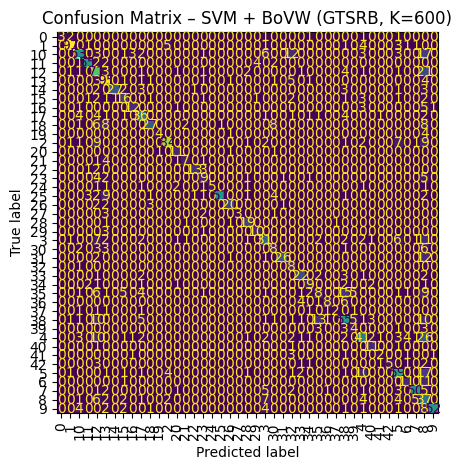

In [8]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt



# Εδώ χρησιμοποιούμε τους modified φακέλους που είδες πριν
TRAIN_PATH = os.path.join(EXTRACTED_ROOT, "train_modified")
TEST_PATH  = os.path.join(EXTRACTED_ROOT, "test_modified")

# Αν για κάποιο λόγο δεν υπάρχουν, κάνε fallback σε απλό train/test
if not os.path.exists(TRAIN_PATH):
    alt_train = os.path.join(EXTRACTED_ROOT, "train")
    if os.path.exists(alt_train):
        TRAIN_PATH = alt_train

if not os.path.exists(TEST_PATH):
    alt_test = os.path.join(EXTRACTED_ROOT, "test")
    if os.path.exists(alt_test):
        TEST_PATH = alt_test

# Unzip μόνο αν δεν υπάρχει ήδη ο φάκελος train_modified/train
if not os.path.exists(TRAIN_PATH):
    print("Unzipping GTSRB dataset...")
    # -n => μην κάνει overwrite, -q => quiet
    !unzip -n -q "{ZIP_PATH}" -d "{ROOT_DIR}"
    print("Dataset unzipped.")
else:
    print("Dataset already unzipped.")

print("TRAIN_PATH:", TRAIN_PATH)
print("TEST_PATH:", TEST_PATH)

# --------------------------------------------------
# 1. Φόρτωση εικόνων (με resize)
# --------------------------------------------------
IMG_SIZE = (48, 48)  # μπορείς να το αλλάξεις σε (32, 32) ή (64, 64)

def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(
        [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    )

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if not os.path.isfile(file_path):
                continue
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(idx)
    return images, np.array(labels), class_names

X_train, y_train, class_names = load_images_from_folder(TRAIN_PATH)
X_test, y_test, _ = load_images_from_folder(TEST_PATH)

print(f"Train images: {len(X_train)}, Test images: {len(X_test)}")
print(f"Number of classes: {len(class_names)}")

# --------------------------------------------------
# 2. SIFT descriptors
# --------------------------------------------------
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        descriptors_list.append(des)
    return descriptors_list

train_desc = extract_sift_features(X_train)
test_desc  = extract_sift_features(X_test)

train_desc_nonempty = [d for d in train_desc if d is not None]
print(f"Images with SIFT descriptors (train): {len(train_desc_nonempty)}")

# --------------------------------------------------
# 3. BoVW με νέο K + Hellinger κανονικοποίηση
# --------------------------------------------------
K_STAR_GTSRB = 600  # <<--- ΑΛΛΑΓΗ: νέο K (δοκίμασε κι άλλα αν θες)

all_descriptors = np.vstack(train_desc_nonempty)
print("All descriptors shape:", all_descriptors.shape)

kmeans = MiniBatchKMeans(
    n_clusters=K_STAR_GTSRB,
    batch_size=2048,
    random_state=0,
    n_init="auto",
)
kmeans.fit(all_descriptors)

def build_bovw_histograms(descriptors_list, kmeans, K):
    histograms = []
    eps = 1e-12

    for descriptors in descriptors_list:
        hist = np.zeros(K, dtype=np.float32)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                hist[label] += 1

        # L1 normalization
        hist = hist / (np.sum(hist) + eps)

        # Hellinger transform (sqrt)
        hist = np.sqrt(hist)

        # L2 normalization
        hist = hist / (np.linalg.norm(hist) + eps)

        histograms.append(hist)

    return np.array(histograms)

X_train_bovw = build_bovw_histograms(train_desc, kmeans, K_STAR_GTSRB)
X_test_bovw  = build_bovw_histograms(test_desc,  kmeans, K_STAR_GTSRB)

print("X_train_bovw shape:", X_train_bovw.shape)
print("X_test_bovw shape:", X_test_bovw.shape)

# --------------------------------------------------
# 4. SVM με class_weight="balanced" + Grid Search στο C
# --------------------------------------------------
C_grid = [0.01, 0.1, 1, 10]

svm_base = SVC(
    kernel="linear",
    decision_function_shape="ovr",
    class_weight="balanced"
)

grid = GridSearchCV(
    svm_base,
    param_grid={"C": C_grid},
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Ξεκινάει το grid search στο C για K =", K_STAR_GTSRB)
grid.fit(X_train_bovw, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

svm_best = grid.best_estimator_

# --------------------------------------------------
# 5. Αξιολόγηση στο test set
# --------------------------------------------------
svm_preds = svm_best.predict(X_test_bovw)
svm_acc = accuracy_score(y_test, svm_preds)

print(f"\n✅ Τελικό SVM+BOVW στο GTSRB (K={K_STAR_GTSRB}, best C={grid.best_params_['C']}) – Test Accuracy: {svm_acc:.4f}")

print("\n📊 Classification report (SVM + BoVW, Hellinger, balanced SVM):")
print(classification_report(y_test, svm_preds, target_names=class_names))

cm = confusion_matrix(y_test, svm_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=90, colorbar=False)
plt.title(f"Confusion Matrix – SVM + BoVW (GTSRB, K={K_STAR_GTSRB})")
plt.tight_layout()
plt.show()


Δοκιμάστηκαν δύο μεγέθη οπτικού λεξιλογίου, K = 400 και K = 600.
Η αύξηση του K βελτίωσε τη γενική επίδοση από 55.98% σε 59.35% test accuracy, ενώ το macro F1 αυξήθηκε από ~0.53 σε ~0.57. Αυτό υποδεικνύει ότι ένα πιο πλούσιο οπτικό λεξιλόγιο επιτρέπει στο μοντέλο να διακρίνει πιο αποτελεσματικά μεταξύ οπτικά παρόμοιων σημάτων, χωρίς να οδηγεί σε υπερπροσαρμογή δεδομένου του διαθέσιμου πλήθους descriptors

Dataset already unzipped.
TRAIN_PATH: /content/GTSRB/GTSRB/train_modified
TEST_PATH: /content/GTSRB/GTSRB/test_modified
Train images: 3977, Test images: 1983
Number of classes: 43
Images with SIFT descriptors (train): 3615
All descriptors shape: (73751, 128)
X_train_bovw shape: (3977, 600)
X_test_bovw shape: (1983, 600)
X_train_color_hist shape: (3977, 512)
X_test_color_hist shape: (1983, 512)
Final feature shapes: (3977, 1112) (1983, 1112)
Ξεκινάει το grid search στο C με BoVW + HSV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 10}
Best CV score: 0.6914770862384625

✅ Τελικό SVM + BoVW + Color hist στο GTSRB (K=600, best C=10) – Test Accuracy: 0.5482

📊 Classification report (SVM + BoVW + Color):
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.59      0.85      0.70       114
          10       0.55      0.66      0.60       104
          11       0.66      0.89      0

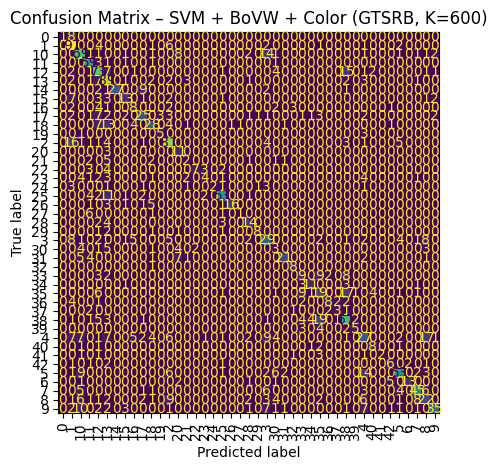

In [9]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# --------------------------------------------------
# 0. Paths & unzip (ίδιο setup με πριν)
# εκεί που είναι τα train_modified/test_modified

TRAIN_PATH = os.path.join(EXTRACTED_ROOT, "train_modified")
TEST_PATH  = os.path.join(EXTRACTED_ROOT, "test_modified")

# Fallback αν λείπουν οι modified φάκελοι
if not os.path.exists(TRAIN_PATH):
    alt_train = os.path.join(EXTRACTED_ROOT, "train")
    if os.path.exists(alt_train):
        TRAIN_PATH = alt_train

if not os.path.exists(TEST_PATH):
    alt_test = os.path.join(EXTRACTED_ROOT, "test")
    if os.path.exists(alt_test):
        TEST_PATH = alt_test

if not os.path.exists(TRAIN_PATH):
    print("Unzipping GTSRB dataset...")
    !unzip -n -q "{ZIP_PATH}" -d "{ROOT_DIR}"
    print("Dataset unzipped.")
else:
    print("Dataset already unzipped.")

print("TRAIN_PATH:", TRAIN_PATH)
print("TEST_PATH:", TEST_PATH)

# --------------------------------------------------
# 1. Φόρτωση εικόνων (και grayscale και color)
# --------------------------------------------------
IMG_SIZE = (48, 48)  # ίδιο μέγεθος με πριν

def load_images_from_folder(folder):
    images_gray = []
    images_color = []
    labels = []
    class_names = sorted(
        [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    )

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if not os.path.isfile(file_path):
                continue

            img_color = cv2.imread(file_path)  # BGR
            if img_color is None:
                continue

            img_color = cv2.resize(img_color, IMG_SIZE)
            img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

            images_color.append(img_color)
            images_gray.append(img_gray)
            labels.append(idx)

    return images_gray, images_color, np.array(labels), class_names

X_train_gray, X_train_color, y_train, class_names = load_images_from_folder(TRAIN_PATH)
X_test_gray,  X_test_color,  y_test, _          = load_images_from_folder(TEST_PATH)

print(f"Train images: {len(X_train_gray)}, Test images: {len(X_test_gray)}")
print(f"Number of classes: {len(class_names)}")

# --------------------------------------------------
# 2. SIFT descriptors (σε grayscale)
# --------------------------------------------------
sift = cv2.SIFT_create()

def extract_sift_features(images_gray):
    descriptors_list = []
    for img in images_gray:
        kp, des = sift.detectAndCompute(img, None)
        descriptors_list.append(des)
    return descriptors_list

train_desc = extract_sift_features(X_train_gray)
test_desc  = extract_sift_features(X_test_gray)

train_desc_nonempty = [d for d in train_desc if d is not None]
print(f"Images with SIFT descriptors (train): {len(train_desc_nonempty)}")

# --------------------------------------------------
# 3. BoVW (K = 600) + Hellinger κανονικοποίηση
# --------------------------------------------------
K_STAR_GTSRB = 600

all_descriptors = np.vstack(train_desc_nonempty)
print("All descriptors shape:", all_descriptors.shape)

kmeans = MiniBatchKMeans(
    n_clusters=K_STAR_GTSRB,
    batch_size=2048,
    random_state=0,
    n_init="auto",
)
kmeans.fit(all_descriptors)

def build_bovw_histograms(descriptors_list, kmeans, K):
    histograms = []
    eps = 1e-12

    for descriptors in descriptors_list:
        hist = np.zeros(K, dtype=np.float32)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                hist[label] += 1

        # L1 normalization
        hist = hist / (np.sum(hist) + eps)

        # Hellinger transform (sqrt)
        hist = np.sqrt(hist)

        # L2 normalization
        hist = hist / (np.linalg.norm(hist) + eps)

        histograms.append(hist)

    return np.array(histograms)

X_train_bovw = build_bovw_histograms(train_desc, kmeans, K_STAR_GTSRB)
X_test_bovw  = build_bovw_histograms(test_desc,  kmeans, K_STAR_GTSRB)

print("X_train_bovw shape:", X_train_bovw.shape)
print("X_test_bovw shape:", X_test_bovw.shape)

# --------------------------------------------------
# 4. Χρωματικά ιστογράμματα (HSV 3D, 8x8x8)
# --------------------------------------------------
def extract_hsv_color_hist(images_color, bins=(8, 8, 8)):
    hist_list = []
    eps = 1e-12

    for img in images_color:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist(
            [hsv],
            [0, 1, 2],             # H, S, V channels
            None,
            bins,
            [0, 180, 0, 256, 0, 256]
        )
        hist = hist.flatten().astype(np.float32)
        hist = hist / (np.sum(hist) + eps)  # L1
        hist = hist / (np.linalg.norm(hist) + eps)  # L2
        hist_list.append(hist)

    return np.array(hist_list)

X_train_color_hist = extract_hsv_color_hist(X_train_color, bins=(8, 8, 8))
X_test_color_hist  = extract_hsv_color_hist(X_test_color,  bins=(8, 8, 8))

print("X_train_color_hist shape:", X_train_color_hist.shape)
print("X_test_color_hist shape:", X_test_color_hist.shape)

# --------------------------------------------------
# 5. Συνένωση BoVW + Color Features
# --------------------------------------------------
X_train_feat = np.hstack([X_train_bovw, X_train_color_hist])
X_test_feat  = np.hstack([X_test_bovw,  X_test_color_hist])

print("Final feature shapes:", X_train_feat.shape, X_test_feat.shape)

# --------------------------------------------------
# 6. SVM με class_weight="balanced" + Grid Search στο C
# --------------------------------------------------
C_grid = [0.01, 0.1, 1, 10]

svm_base = SVC(
    kernel="linear",
    decision_function_shape="ovr",
    class_weight="balanced"
)

grid = GridSearchCV(
    svm_base,
    param_grid={"C": C_grid},
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Ξεκινάει το grid search στο C με BoVW + HSV...")
grid.fit(X_train_feat, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

svm_best = grid.best_estimator_

# --------------------------------------------------
# 7. Αξιολόγηση στο test set
# --------------------------------------------------
svm_preds = svm_best.predict(X_test_feat)
svm_acc = accuracy_score(y_test, svm_preds)

print(f"\n✅ Τελικό SVM + BoVW + Color hist στο GTSRB (K={K_STAR_GTSRB}, best C={grid.best_params_['C']}) – Test Accuracy: {svm_acc:.4f}")

print("\n📊 Classification report (SVM + BoVW + Color):")
print(classification_report(y_test, svm_preds, target_names=class_names))

cm = confusion_matrix(y_test, svm_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=90, colorbar=False)
plt.title(f"Confusion Matrix – SVM + BoVW + Color (GTSRB, K={K_STAR_GTSRB})")
plt.tight_layout()
plt.show()


χειροττερο